In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os
from dotenv import load_dotenv
import psycopg2 as pg2

## Amenities Exploration

The purpose of this exploration is to determine the most common amenities, and to see if there are any other amenities that are correlated to a higher price. This will allow homeowners to determine if there are any amenities that they may need to purchase in order to best serve their guests, and to see which amenities may increase the value of their listing.

## Important Considerations

From [this link](https://www1.nyc.gov/site/specialenforcement/stay-in-the-know/information-for-hosts.page), we know that the following information applies to New York City short-term rentals

* "You cannot rent out an entire apartment or home to visitors for less than 30 days, even if you own or live in the building."   

* "You must be present during your guests' stay if it is for less than 30 days."   

* "You may have up to two paying guests staying in your household for fewer than 30 days, only if every guest has free and unobstructed access to every room, and each exit within the apartment."

Because of this, we will conduct an analysis of amenities separately for private rooms and for entire residences.

## Obtaining the Data From Postgres

In [2]:
load_dotenv()

conn = pg2.connect(
    database = os.getenv('POSTGRES_DATABASE'),
    user = os.getenv('POSTGRES_USER'),
    password = os.getenv('POSTGRES_PASSWORD')
)

cursor = conn.cursor()

cursor.execute('''
    SELECT
        id,
        name,
        neighborhood_group,
        neighborhood,
        room_type,
        amenities,
        price
            FROM nyc_airbnb
''')

result = cursor.fetchall()

conn.close()

In [3]:
df = pd.DataFrame(data = result)

In [4]:
df.head()

,0,1,2,3,4,5,6
0,850148,Room in a artist loft,Brooklyn,Williamsburg,Private room,"[Essentials, TV with standard cable, Cable TV,...",69
1,850198,"UES 1 br, 2 blocks from the Met",Manhattan,Upper East Side,Entire home/apt,"[Essentials, Dishwasher, Host greets you, Heat...",190
2,850338,Authentic Luxury Designed Loft,Brooklyn,Williamsburg,Entire home/apt,"[Essentials, Dishwasher, Heating, BBQ grill, D...",143
3,850517,3 Bedroom Duplex/ 2 Baths and 2 LR,Brooklyn,Bushwick,Entire home/apt,"[Essentials, TV with standard cable, Long term...",289
4,850712,Cute Studio Greenwich Village NYC,Manhattan,Greenwich Village,Entire home/apt,"[Long term stays allowed, Refrigerator, Smart ...",120


## Cleaning the Data

In [5]:
# Recall that price reflects price per night

df.rename(columns = {
    0: 'id',
    1: 'name',
    2: 'neighborhood_group',
    3: 'neighborhood',
    4: 'room_type',
    5: 'amenities',
    6: 'price'
}, inplace = True)

In [6]:
df.head()

,id,name,neighborhood_group,neighborhood,room_type,amenities,price
0,850148,Room in a artist loft,Brooklyn,Williamsburg,Private room,"[Essentials, TV with standard cable, Cable TV,...",69
1,850198,"UES 1 br, 2 blocks from the Met",Manhattan,Upper East Side,Entire home/apt,"[Essentials, Dishwasher, Host greets you, Heat...",190
2,850338,Authentic Luxury Designed Loft,Brooklyn,Williamsburg,Entire home/apt,"[Essentials, Dishwasher, Heating, BBQ grill, D...",143
3,850517,3 Bedroom Duplex/ 2 Baths and 2 LR,Brooklyn,Bushwick,Entire home/apt,"[Essentials, TV with standard cable, Long term...",289
4,850712,Cute Studio Greenwich Village NYC,Manhattan,Greenwich Village,Entire home/apt,"[Long term stays allowed, Refrigerator, Smart ...",120


In [7]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

We are not interested in hotel rooms, so we can drop these values from our DataFrame.

In [8]:
df[df['room_type'] == 'Hotel room'].index

Int64Index([ 1705,  5056,  8394,  8398, 10221, 10241, 10947, 11708, 13356,
            13372,
            ...
            29195, 29273, 29703, 31009, 31343, 31439, 35674, 35687, 35700,
            35924],
           dtype='int64', length=259)

In [9]:
df.drop(
    labels = df[df['room_type'] == 'Hotel room'].index,
    axis = 0,
    inplace = True
)

df.reset_index(inplace = True)

df.drop(
    'index',
    axis = 1,
    inplace = True
)

In [10]:
df

,id,name,neighborhood_group,neighborhood,room_type,amenities,price
0,850148,Room in a artist loft,Brooklyn,Williamsburg,Private room,"[Essentials, TV with standard cable, Cable TV,...",69
1,850198,"UES 1 br, 2 blocks from the Met",Manhattan,Upper East Side,Entire home/apt,"[Essentials, Dishwasher, Host greets you, Heat...",190
2,850338,Authentic Luxury Designed Loft,Brooklyn,Williamsburg,Entire home/apt,"[Essentials, Dishwasher, Heating, BBQ grill, D...",143
3,850517,3 Bedroom Duplex/ 2 Baths and 2 LR,Brooklyn,Bushwick,Entire home/apt,"[Essentials, TV with standard cable, Long term...",289
4,850712,Cute Studio Greenwich Village NYC,Manhattan,Greenwich Village,Entire home/apt,"[Long term stays allowed, Refrigerator, Smart ...",120
...,...,...,...,...,...,...,...
36460,849409,Spacious garden appartment brooklyn,Brooklyn,Prospect Heights,Entire home/apt,"[Essentials, Free street parking, Long term st...",129
36461,849567,Your own large 1BR apt in Manhattan,Manhattan,Inwood,Entire home/apt,"[Essentials, Free street parking, Long term st...",80
36462,849603,Spacious Crown Heights Apartment,Brooklyn,Crown Heights,Entire home/apt,"[Essentials, Free street parking, Long term st...",80
36463,849703,"Convenient, Renovated 2 Bedroom",Brooklyn,Carroll Gardens,Entire home/apt,"[Essentials, TV with standard cable, Long term...",250


In [11]:
# Checking the above alteration

print (df['room_type'].unique())

['Private room' 'Entire home/apt' 'Shared room']


## Determining the Most Common Items

In [12]:
# Create a series that gives each item in the listing's 'amenities' list a row
# a_list is short for amenities list

a_list = pd.Series(np.concatenate(df['amenities']))

<AxesSubplot:>

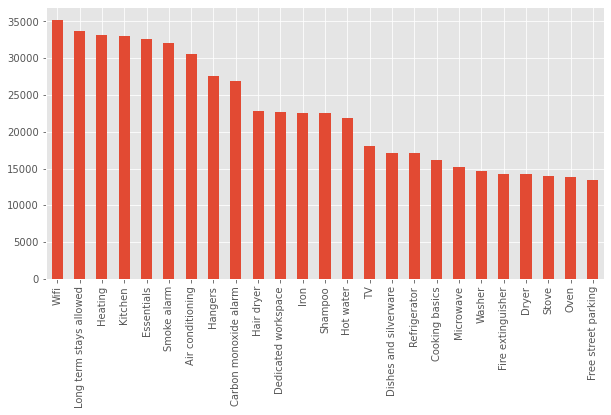

In [13]:
a_list.value_counts().nlargest(25).plot(kind = 'bar', figsize = (10, 5))

From the above, we can conclude that the most common amenities across all room types are wifi, along with safety and kitchen essentials.

Clarification for what are considered essentials can be found [here](https://www.airbnb.com/help/article/2343/what-are-essential-amenities), and information regarding long term stays can be found [here](https://www.airbnb.com/help/article/1354/what-are-some-differences-between-longterm-hosting-and-shortterm-hosting).

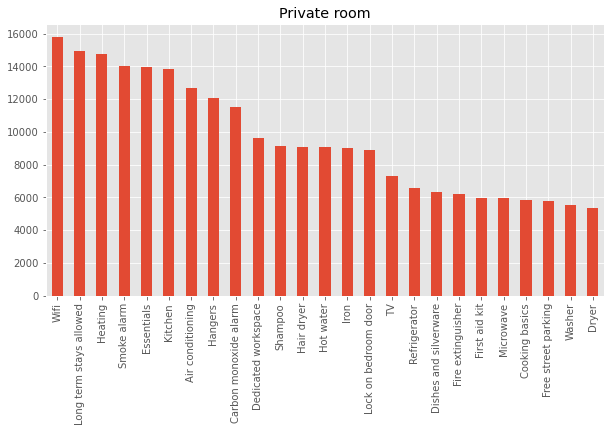

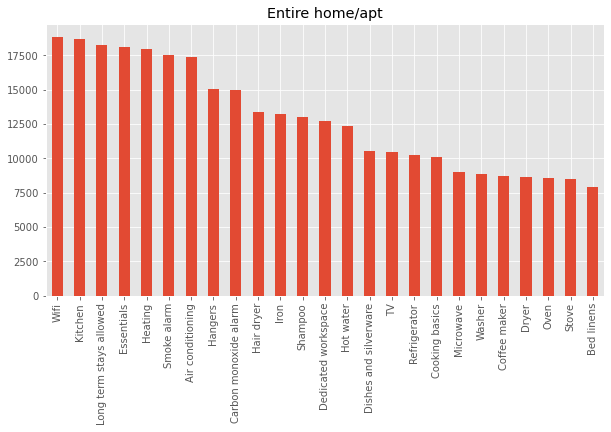

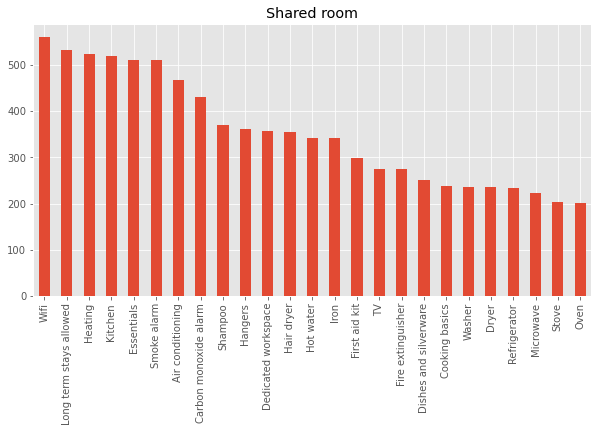

In [14]:
room_type_amens_counts = []

# Get a series of the amenities per room_type

for room_type in df['room_type'].unique():
    room_type_amens_counts.append(
        df[df['room_type'] == room_type]['amenities'].reset_index().drop('index', axis = 1).squeeze()
    )
    
# Concatenate every series in the list, then create the value_counts() plot
# Need to wrap everything in pd.Series in order to have access to Series methods

for ind in range(0, len(room_type_amens_counts)):
    plt.figure()
    
    pd.Series(
        np.concatenate(room_type_amens_counts[ind])).value_counts().nlargest(25).plot(
            kind = 'bar', figsize = (10, 5), title = df['room_type'].unique()[ind]
    )
    
    plt.show()
    

Given that these are the most common items among each room type, prospective homeowners for each category should consider having most these items available for their guests.

## Determining the Common Amenities Among Various Price Ranges

We now proceed to determine which amenities are common among various price ranges. This will help prospective homeowners determine if they can potentially increase the price per night by investing in certain amenities.

In [15]:
df['price'].describe()

count    36465.000000
mean       159.163307
std        293.775429
min         10.000000
25%         67.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [16]:
# We will use the above information to help determine the ranges
# Ranges in the list below can be altered as desired

price_ranges = [
    [0, 49],
    [50, 100],
    [101, 175],
    [175, 300],
    [300, 1000]
]

def range_query(low, high):
    return df[(df['price'] >= low) & (df['price'] <= high)]

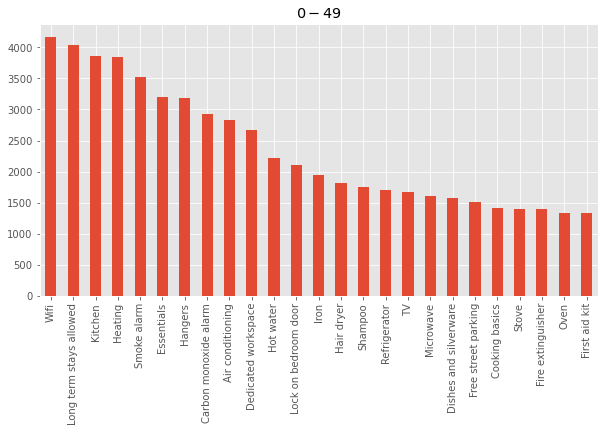

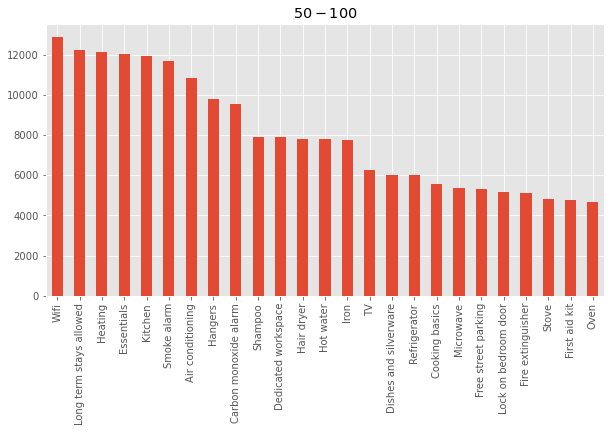

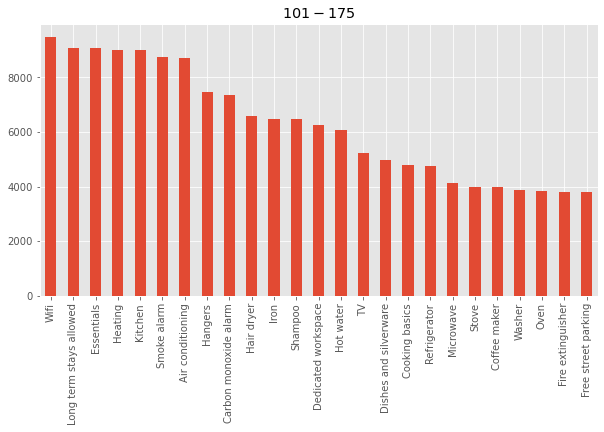

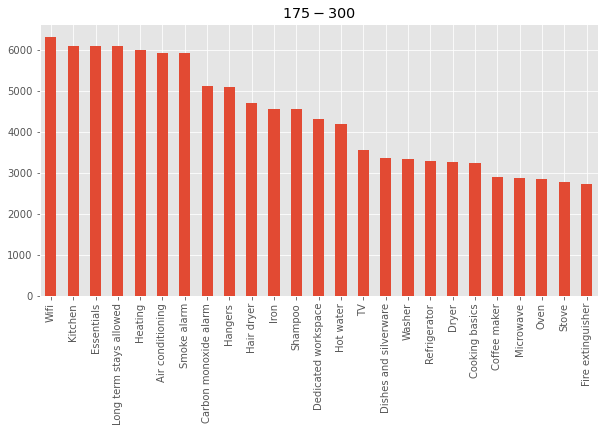

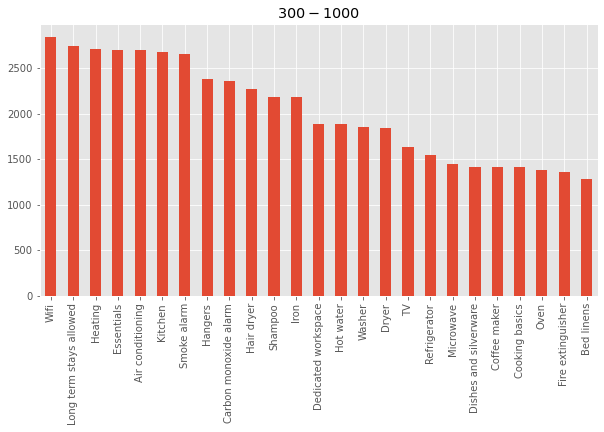

In [17]:
price_range_series = []

for price in price_ranges:
    price_range_series.append(
        range_query(price[0], price[1])['amenities'].reset_index().drop('index', axis = 1).squeeze()
    )
    
for ind in range(0, len(price_range_series)):
    plt.figure()
    
    pd.Series(
        np.concatenate(price_range_series[ind])).value_counts().nlargest(25).plot(
            kind = 'bar', figsize = (10, 5), title = f'${price_ranges[ind][0]} - ${price_ranges[ind][1]}'
    )
    
    plt.show()

From the above, we can conclude that there are no major differences in amenities between price ranges.